<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [GTSRB4] - Data augmentation 
<!-- DESC --> Episode 4 : Adding data by data augmentation when we lack it, to improve our results
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
  - Trying to improve training by **enhancing the data**
  - Using Keras' **data augmentation utilities**, finding their limits...
  
The German Traffic Sign Recognition Benchmark (GTSRB) is a dataset with more than 50,000 photos of road signs from about 40 classes.  
The final aim is to recognise them !  

Description is available there : http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset


## What we're going to do :
 - Increase and improve the training dataset
 - Identify the limits of these tools

## Step 1 - Import and init
### 1.1 - Python stuffs

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard

import numpy as np
import h5py

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import os, sys, time, random

from importlib import reload

sys.path.append('..')
import fidle.pwk as pwk

run_dir = './run/GTSRB4.001'
datasets_dir = pwk.init('GTSRB4', run_dir)

**\*\* Overrided parameters : \*\***

run_dir              : ./run/GTSRB4_done


<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0.12
Notebook id          : GTSRB4
Run time             : Tuesday 09 February 2021, 18:46:45
TensorFlow version   : 2.4.0
Keras version        : 2.4.0
Datasets dir         : /gpfswork/rech/mlh/uja62cb/datasets
Run dir              : ./run/GTSRB4_done
Update keras cache   : False
Save figs            : True
Path figs            : ./run/GTSRB4_done/figs


### 1.2 - Parameters
`scale` is the proportion of the dataset that will be used during the training. (1 mean 100%)  

In [2]:
enhanced_dir = f'{datasets_dir}/GTSRB/enhanced'
dataset_name = 'set-24x24-L'
batch_size   = 64
epochs       = 5
scale        = 1

enhanced_dir = './data'

Override parameters (batch mode) - Just forget this cell

In [3]:
pwk.override('enhanced_dir', 'dataset_name', 'batch_size', 'epochs', 'scale')

**\*\* Overrided parameters : \*\***

enhanced_dir         : /gpfswork/rech/mlh/uja62cb/datasets/GTSRB/enhanced
dataset_name         : set-24x24-L
batch_size           : 64
epochs               : 5
scale                : 1


## Step 2 - Load dataset
Dataset is one of the saved dataset: RGB25, RGB35, L25, L35, etc.  
First of all, we're going to use a smart dataset : **set-24x24-L**  
(with a GPU, it only takes 35'' compared to more than 5' with a CPU !)

In [4]:
def read_dataset(enhanced_dir, dataset_name):
    '''Reads h5 dataset
    Args:
        filename     : datasets filename
        dataset_name : dataset name, without .h5
    Returns:    x_train,y_train, x_test,y_test data, x_meta,y_meta'''
    # ---- Read dataset
    pwk.chrono_start()
    filename = f'{enhanced_dir}/{dataset_name}.h5'
    with  h5py.File(filename,'r') as f:
        x_train = f['x_train'][:]
        y_train = f['y_train'][:]
        x_test  = f['x_test'][:]
        y_test  = f['y_test'][:]
        x_meta  = f['x_meta'][:]
        y_meta  = f['y_meta'][:]
    print(x_train.shape, y_train.shape)
    # ---- Shuffle
    x_train,y_train=pwk.shuffle_np_dataset(x_train,y_train)

    # ---- done
    duration = pwk.chrono_stop(hdelay=True)
    size     = pwk.hsize(os.path.getsize(filename))
    print(f'Dataset "{dataset_name}" is loaded and shuffled. ({size} in {duration})')
    return x_train,y_train, x_test,y_test, x_meta,y_meta

# ---- Read dataset
#
x_train,y_train,x_test,y_test, x_meta,y_meta = read_dataset(enhanced_dir, dataset_name)

# ---- Rescale 
#
x_train,y_train, x_test,y_test = pwk.rescale_dataset(x_train,y_train,x_test,y_test, scale=scale)

(39209, 24, 24, 1) (39209,)
Dataset "set-24x24-L" is loaded and shuffled. (228.8 Mo in 00:00:00 152ms)


## Step 3 - Models
We will now build a model and train it...

This is my model ;-) 

In [5]:
# A basic model
#
def get_model_v1(lx,ly,lz):
    
    model = keras.models.Sequential()
    
    model.add( keras.layers.Conv2D(96, (3,3), activation='relu', input_shape=(lx,ly,lz)))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(192, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Flatten()) 
    model.add( keras.layers.Dense(1500, activation='relu'))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Dense(43, activation='softmax'))
    return model

## Step 4 - Callbacks  
We prepare 2 kind callbacks :  TensorBoard and Model backup

In [6]:
pwk.mkdir(run_dir + '/models')
pwk.mkdir(run_dir + '/logs')

# ---- Callback tensorboard
log_dir = run_dir + "/logs/tb_" + pwk.tag_now()
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# ---- Callback ModelCheckpoint - Save best model
save_dir = run_dir + "/models/best-model.h5"
bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, monitor='accuracy', save_best_only=True)

# ---- Callback ModelCheckpoint - Save model each epochs
save_dir = run_dir + "/models/model-{epoch:04d}.h5"
savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0)

print(f'To run tensorboard, use :  --logdir {run_dir}/logs')

To run tensorboard, use :  --logdir ./run/GTSRB4_done/logs


## Step 5 - Data augmentation

In [7]:
datagen = keras.preprocessing.image.ImageDataGenerator(featurewise_center=False,
                             featurewise_std_normalization=False,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10.)
datagen.fit(x_train)

## Step 6 - Train the model
**Get my data shape :**

In [8]:
(n,lx,ly,lz) = x_train.shape
print("Images of the dataset have this folowing shape : ",(lx,ly,lz))

Images of the dataset have this folowing shape :  (24, 24, 1)


**Get and compile a model, with the data shape :**

In [9]:
model = get_model_v1(lx,ly,lz)

# model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

**Train it :** 

In [10]:
pwk.chrono_start()

history = model.fit(  datagen.flow(x_train, y_train, batch_size=batch_size),
                      steps_per_epoch = int(x_train.shape[0]/batch_size),
                      epochs=epochs,
                      verbose=1,
                      validation_data=(x_test, y_test),
                      callbacks=[tensorboard_callback, bestmodel_callback, savemodel_callback] )

model.save(f'{run_dir}/models/last-model.h5')

pwk.chrono_show()

Epoch 1/5


  1/612 [..............................] - ETA: 29:22 - loss: 3.7534 - accuracy: 0.0312

  3/612 [..............................] - ETA: 1:06 - loss: 3.7519 - accuracy: 0.0356 

  7/612 [..............................] - ETA: 28s - loss: 3.7345 - accuracy: 0.0370 

 11/612 [..............................] - ETA: 20s - loss: 3.7067 - accuracy: 0.0404

 15/612 [..............................] - ETA: 16s - loss: 3.6876 - accuracy: 0.0423

 19/612 [..............................] - ETA: 15s - loss: 3.6748 - accuracy: 0.0439

 23/612 [>.............................] - ETA: 13s - loss: 3.6646 - accuracy: 0.0446

 27/612 [>.............................] - ETA: 12s - loss: 3.6547 - accuracy: 0.0456

 31/612 [>.............................] - ETA: 12s - loss: 3.6469 - accuracy: 0.0468

 35/612 [>.............................] - ETA: 11s - loss: 3.6398 - accuracy: 0.0478

 39/612 [>.............................] - ETA: 11s - loss: 3.6336 - accuracy: 0.0486

 43/612 [=>............................] - ETA: 11s - loss: 3.6281 - accuracy: 0.0492

 47/612 [=>............................] - ETA: 10s - loss: 3.6225 - accuracy: 0.0500

 51/612 [=>............................] - ETA: 10s - loss: 3.6170 - accuracy: 0.0508

 55/612 [=>............................] - ETA: 10s - loss: 3.6118 - accuracy: 0.0516

 59/612 [=>............................] - ETA: 10s - loss: 3.6065 - accuracy: 0.0524

 63/612 [==>...........................] - ETA: 9s - loss: 3.6013 - accuracy: 0.0532 

 67/612 [==>...........................] - ETA: 9s - loss: 3.5959 - accuracy: 0.0540

 71/612 [==>...........................] - ETA: 9s - loss: 3.5906 - accuracy: 0.0549

 75/612 [==>...........................] - ETA: 9s - loss: 3.5854 - accuracy: 0.0557

 79/612 [==>...........................] - ETA: 9s - loss: 3.5805 - accuracy: 0.0566

 83/612 [===>..........................] - ETA: 9s - loss: 3.5761 - accuracy: 0.0573

 87/612 [===>..........................] - ETA: 8s - loss: 3.5718 - accuracy: 0.0581

 91/612 [===>..........................] - ETA: 8s - loss: 3.5676 - accuracy: 0.0588

 95/612 [===>..........................] - ETA: 8s - loss: 3.5636 - accuracy: 0.0594

 99/612 [===>..........................] - ETA: 8s - loss: 3.5598 - accuracy: 0.0601

103/612 [====>.........................] - ETA: 8s - loss: 3.5559 - accuracy: 0.0607

107/612 [====>.........................] - ETA: 8s - loss: 3.5521 - accuracy: 0.0614

111/612 [====>.........................] - ETA: 8s - loss: 3.5483 - accuracy: 0.0621

115/612 [====>.........................] - ETA: 8s - loss: 3.5446 - accuracy: 0.0629

119/612 [====>.........................] - ETA: 8s - loss: 3.5410 - accuracy: 0.0636

123/612 [=====>........................] - ETA: 8s - loss: 3.5373 - accuracy: 0.0644

127/612 [=====>........................] - ETA: 7s - loss: 3.5337 - accuracy: 0.0652

131/612 [=====>........................] - ETA: 7s - loss: 3.5301 - accuracy: 0.0661

135/612 [=====>........................] - ETA: 7s - loss: 3.5264 - accuracy: 0.0669

139/612 [=====>........................] - ETA: 7s - loss: 3.5226 - accuracy: 0.0678

143/612 [======>.......................] - ETA: 7s - loss: 3.5188 - accuracy: 0.0687

147/612 [======>.......................] - ETA: 7s - loss: 3.5149 - accuracy: 0.0697

151/612 [======>.......................] - ETA: 7s - loss: 3.5109 - accuracy: 0.0707

155/612 [======>.......................] - ETA: 7s - loss: 3.5069 - accuracy: 0.0717

159/612 [======>.......................] - ETA: 7s - loss: 3.5027 - accuracy: 0.0727

163/612 [======>.......................] - ETA: 7s - loss: 3.4985 - accuracy: 0.0738

167/612 [=======>......................] - ETA: 7s - loss: 3.4943 - accuracy: 0.0748

171/612 [=======>......................] - ETA: 7s - loss: 3.4899 - accuracy: 0.0759

175/612 [=======>......................] - ETA: 6s - loss: 3.4854 - accuracy: 0.0770

179/612 [=======>......................] - ETA: 6s - loss: 3.4809 - accuracy: 0.0782

183/612 [=======>......................] - ETA: 6s - loss: 3.4762 - accuracy: 0.0793

187/612 [========>.....................] - ETA: 6s - loss: 3.4715 - accuracy: 0.0805

191/612 [========>.....................] - ETA: 6s - loss: 3.4666 - accuracy: 0.0817

195/612 [========>.....................] - ETA: 6s - loss: 3.4616 - accuracy: 0.0830

199/612 [========>.....................] - ETA: 6s - loss: 3.4565 - accuracy: 0.0842

203/612 [========>.....................] - ETA: 6s - loss: 3.4513 - accuracy: 0.0855

207/612 [=========>....................] - ETA: 6s - loss: 3.4460 - accuracy: 0.0868

211/612 [=========>....................] - ETA: 6s - loss: 3.4406 - accuracy: 0.0882

215/612 [=========>....................] - ETA: 6s - loss: 3.4351 - accuracy: 0.0895

219/612 [=========>....................] - ETA: 6s - loss: 3.4294 - accuracy: 0.0909

223/612 [=========>....................] - ETA: 6s - loss: 3.4237 - accuracy: 0.0923

227/612 [==========>...................] - ETA: 6s - loss: 3.4180 - accuracy: 0.0937

231/612 [==========>...................] - ETA: 5s - loss: 3.4122 - accuracy: 0.0951

235/612 [==========>...................] - ETA: 5s - loss: 3.4064 - accuracy: 0.0966

239/612 [==========>...................] - ETA: 5s - loss: 3.4006 - accuracy: 0.0980

243/612 [==========>...................] - ETA: 5s - loss: 3.3947 - accuracy: 0.0995

247/612 [===========>..................] - ETA: 5s - loss: 3.3888 - accuracy: 0.1009

251/612 [===========>..................] - ETA: 5s - loss: 3.3828 - accuracy: 0.1024

255/612 [===========>..................] - ETA: 5s - loss: 3.3767 - accuracy: 0.1039

259/612 [===========>..................] - ETA: 5s - loss: 3.3707 - accuracy: 0.1053

263/612 [===========>..................] - ETA: 5s - loss: 3.3646 - accuracy: 0.1068

267/612 [============>.................] - ETA: 5s - loss: 3.3585 - accuracy: 0.1083

271/612 [============>.................] - ETA: 5s - loss: 3.3523 - accuracy: 0.1098

275/612 [============>.................] - ETA: 5s - loss: 3.3462 - accuracy: 0.1113

279/612 [============>.................] - ETA: 5s - loss: 3.3400 - accuracy: 0.1128

283/612 [============>.................] - ETA: 5s - loss: 3.3339 - accuracy: 0.1143

287/612 [=============>................] - ETA: 5s - loss: 3.3277 - accuracy: 0.1158

291/612 [=============>................] - ETA: 4s - loss: 3.3215 - accuracy: 0.1173

295/612 [=============>................] - ETA: 4s - loss: 3.3154 - accuracy: 0.1188

299/612 [=============>................] - ETA: 4s - loss: 3.3092 - accuracy: 0.1203

303/612 [=============>................] - ETA: 4s - loss: 3.3030 - accuracy: 0.1218

307/612 [==============>...............] - ETA: 4s - loss: 3.2968 - accuracy: 0.1232

311/612 [==============>...............] - ETA: 4s - loss: 3.2907 - accuracy: 0.1247

315/612 [==============>...............] - ETA: 4s - loss: 3.2845 - accuracy: 0.1262

319/612 [==============>...............] - ETA: 4s - loss: 3.2783 - accuracy: 0.1277

323/612 [==============>...............] - ETA: 4s - loss: 3.2721 - accuracy: 0.1291

327/612 [===============>..............] - ETA: 4s - loss: 3.2660 - accuracy: 0.1306

331/612 [===============>..............] - ETA: 4s - loss: 3.2598 - accuracy: 0.1321

335/612 [===============>..............] - ETA: 4s - loss: 3.2536 - accuracy: 0.1336

339/612 [===============>..............] - ETA: 4s - loss: 3.2475 - accuracy: 0.1351

343/612 [===============>..............] - ETA: 4s - loss: 3.2413 - accuracy: 0.1365

347/612 [================>.............] - ETA: 4s - loss: 3.2352 - accuracy: 0.1380

351/612 [================>.............] - ETA: 4s - loss: 3.2290 - accuracy: 0.1394

355/612 [================>.............] - ETA: 3s - loss: 3.2229 - accuracy: 0.1409

359/612 [================>.............] - ETA: 3s - loss: 3.2168 - accuracy: 0.1424

363/612 [================>.............] - ETA: 3s - loss: 3.2107 - accuracy: 0.1438

367/612 [================>.............] - ETA: 3s - loss: 3.2046 - accuracy: 0.1453

371/612 [=================>............] - ETA: 3s - loss: 3.1985 - accuracy: 0.1467

375/612 [=================>............] - ETA: 3s - loss: 3.1925 - accuracy: 0.1482

379/612 [=================>............] - ETA: 3s - loss: 3.1864 - accuracy: 0.1496

383/612 [=================>............] - ETA: 3s - loss: 3.1804 - accuracy: 0.1510

387/612 [=================>............] - ETA: 3s - loss: 3.1743 - accuracy: 0.1525

391/612 [==================>...........] - ETA: 3s - loss: 3.1683 - accuracy: 0.1539

395/612 [==================>...........] - ETA: 3s - loss: 3.1623 - accuracy: 0.1553

399/612 [==================>...........] - ETA: 3s - loss: 3.1563 - accuracy: 0.1567

403/612 [==================>...........] - ETA: 3s - loss: 3.1504 - accuracy: 0.1582

407/612 [==================>...........] - ETA: 3s - loss: 3.1444 - accuracy: 0.1596

411/612 [===================>..........] - ETA: 3s - loss: 3.1385 - accuracy: 0.1610

415/612 [===================>..........] - ETA: 3s - loss: 3.1326 - accuracy: 0.1624

419/612 [===================>..........] - ETA: 2s - loss: 3.1268 - accuracy: 0.1638

423/612 [===================>..........] - ETA: 2s - loss: 3.1209 - accuracy: 0.1652

427/612 [===================>..........] - ETA: 2s - loss: 3.1151 - accuracy: 0.1666

431/612 [====================>.........] - ETA: 2s - loss: 3.1093 - accuracy: 0.1680

435/612 [====================>.........] - ETA: 2s - loss: 3.1035 - accuracy: 0.1694

439/612 [====================>.........] - ETA: 2s - loss: 3.0978 - accuracy: 0.1707

443/612 [====================>.........] - ETA: 2s - loss: 3.0920 - accuracy: 0.1721

447/612 [====================>.........] - ETA: 2s - loss: 3.0863 - accuracy: 0.1735

451/612 [=====================>........] - ETA: 2s - loss: 3.0806 - accuracy: 0.1748

455/612 [=====================>........] - ETA: 2s - loss: 3.0749 - accuracy: 0.1762

459/612 [=====================>........] - ETA: 2s - loss: 3.0692 - accuracy: 0.1776

463/612 [=====================>........] - ETA: 2s - loss: 3.0636 - accuracy: 0.1789

467/612 [=====================>........] - ETA: 2s - loss: 3.0579 - accuracy: 0.1803

471/612 [======================>.......] - ETA: 2s - loss: 3.0523 - accuracy: 0.1816

475/612 [======================>.......] - ETA: 2s - loss: 3.0468 - accuracy: 0.1830

479/612 [======================>.......] - ETA: 2s - loss: 3.0412 - accuracy: 0.1843

483/612 [======================>.......] - ETA: 1s - loss: 3.0357 - accuracy: 0.1856

487/612 [======================>.......] - ETA: 1s - loss: 3.0302 - accuracy: 0.1870

491/612 [=======================>......] - ETA: 1s - loss: 3.0247 - accuracy: 0.1883

495/612 [=======================>......] - ETA: 1s - loss: 3.0192 - accuracy: 0.1896

499/612 [=======================>......] - ETA: 1s - loss: 3.0138 - accuracy: 0.1909

503/612 [=======================>......] - ETA: 1s - loss: 3.0083 - accuracy: 0.1922

507/612 [=======================>......] - ETA: 1s - loss: 3.0029 - accuracy: 0.1935

511/612 [========================>.....] - ETA: 1s - loss: 2.9976 - accuracy: 0.1948

515/612 [========================>.....] - ETA: 1s - loss: 2.9922 - accuracy: 0.1961

517/612 [========================>.....] - ETA: 1s - loss: 2.9896 - accuracy: 0.1967

522/612 [========================>.....] - ETA: 1s - loss: 2.9829 - accuracy: 0.1983

526/612 [========================>.....] - ETA: 1s - loss: 2.9776 - accuracy: 0.1996

530/612 [========================>.....] - ETA: 1s - loss: 2.9724 - accuracy: 0.2009

534/612 [=========================>....] - ETA: 1s - loss: 2.9672 - accuracy: 0.2021

538/612 [=========================>....] - ETA: 1s - loss: 2.9620 - accuracy: 0.2034

542/612 [=========================>....] - ETA: 1s - loss: 2.9568 - accuracy: 0.2046

546/612 [=========================>....] - ETA: 1s - loss: 2.9516 - accuracy: 0.2059

550/612 [=========================>....] - ETA: 0s - loss: 2.9465 - accuracy: 0.2071

554/612 [==========================>...] - ETA: 0s - loss: 2.9414 - accuracy: 0.2084

558/612 [==========================>...] - ETA: 0s - loss: 2.9363 - accuracy: 0.2096

562/612 [==========================>...] - ETA: 0s - loss: 2.9313 - accuracy: 0.2108

566/612 [==========================>...] - ETA: 0s - loss: 2.9263 - accuracy: 0.2120

570/612 [==========================>...] - ETA: 0s - loss: 2.9212 - accuracy: 0.2132

574/612 [===========================>..] - ETA: 0s - loss: 2.9162 - accuracy: 0.2145

578/612 [===========================>..] - ETA: 0s - loss: 2.9113 - accuracy: 0.2157

582/612 [===========================>..] - ETA: 0s - loss: 2.9063 - accuracy: 0.2169

586/612 [===========================>..] - ETA: 0s - loss: 2.9014 - accuracy: 0.2181

590/612 [===========================>..] - ETA: 0s - loss: 2.8965 - accuracy: 0.2192

594/612 [============================>.] - ETA: 0s - loss: 2.8916 - accuracy: 0.2204

598/612 [============================>.] - ETA: 0s - loss: 2.8868 - accuracy: 0.2216

602/612 [============================>.] - ETA: 0s - loss: 2.8819 - accuracy: 0.2228

606/612 [============================>.] - ETA: 0s - loss: 2.8771 - accuracy: 0.2240

610/612 [============================>.] - ETA: 0s - loss: 2.8723 - accuracy: 0.2251

612/612 [==============================] - 14s 17ms/step - loss: 2.8688 - accuracy: 0.2260 - val_loss: 0.8546 - val_accuracy: 0.7653


Epoch 2/5
  1/612 [..............................] - ETA: 25s - loss: 1.0710 - accuracy: 0.7188

  5/612 [..............................] - ETA: 9s - loss: 1.1714 - accuracy: 0.6742 

  9/612 [..............................] - ETA: 9s - loss: 1.1701 - accuracy: 0.6715

 13/612 [..............................] - ETA: 9s - loss: 1.1773 - accuracy: 0.6650

 17/612 [..............................] - ETA: 9s - loss: 1.1790 - accuracy: 0.6620

 21/612 [>.............................] - ETA: 9s - loss: 1.1780 - accuracy: 0.6601

 25/612 [>.............................] - ETA: 8s - loss: 1.1763 - accuracy: 0.6588

 29/612 [>.............................] - ETA: 8s - loss: 1.1757 - accuracy: 0.6574

 33/612 [>.............................] - ETA: 8s - loss: 1.1758 - accuracy: 0.6565

 37/612 [>.............................] - ETA: 8s - loss: 1.1743 - accuracy: 0.6564

 41/612 [=>............................] - ETA: 8s - loss: 1.1726 - accuracy: 0.6568

 45/612 [=>............................] - ETA: 8s - loss: 1.1708 - accuracy: 0.6571

 49/612 [=>............................] - ETA: 8s - loss: 1.1700 - accuracy: 0.6572

 53/612 [=>............................] - ETA: 8s - loss: 1.1688 - accuracy: 0.6574

 57/612 [=>............................] - ETA: 8s - loss: 1.1681 - accuracy: 0.6575

 61/612 [=>............................] - ETA: 8s - loss: 1.1678 - accuracy: 0.6574

 65/612 [==>...........................] - ETA: 8s - loss: 1.1675 - accuracy: 0.6573

 69/612 [==>...........................] - ETA: 8s - loss: 1.1675 - accuracy: 0.6572

 73/612 [==>...........................] - ETA: 8s - loss: 1.1674 - accuracy: 0.6573

 77/612 [==>...........................] - ETA: 8s - loss: 1.1669 - accuracy: 0.6574

 81/612 [==>...........................] - ETA: 8s - loss: 1.1665 - accuracy: 0.6575

 85/612 [===>..........................] - ETA: 8s - loss: 1.1661 - accuracy: 0.6576

 89/612 [===>..........................] - ETA: 8s - loss: 1.1656 - accuracy: 0.6577

 93/612 [===>..........................] - ETA: 7s - loss: 1.1648 - accuracy: 0.6579

 97/612 [===>..........................] - ETA: 7s - loss: 1.1639 - accuracy: 0.6580

101/612 [===>..........................] - ETA: 7s - loss: 1.1630 - accuracy: 0.6581

105/612 [====>.........................] - ETA: 7s - loss: 1.1619 - accuracy: 0.6583

109/612 [====>.........................] - ETA: 7s - loss: 1.1607 - accuracy: 0.6586

113/612 [====>.........................] - ETA: 7s - loss: 1.1595 - accuracy: 0.6588

117/612 [====>.........................] - ETA: 7s - loss: 1.1582 - accuracy: 0.6591

121/612 [====>.........................] - ETA: 7s - loss: 1.1569 - accuracy: 0.6594

125/612 [=====>........................] - ETA: 7s - loss: 1.1556 - accuracy: 0.6596

129/612 [=====>........................] - ETA: 7s - loss: 1.1544 - accuracy: 0.6598

133/612 [=====>........................] - ETA: 7s - loss: 1.1533 - accuracy: 0.6600

137/612 [=====>........................] - ETA: 7s - loss: 1.1522 - accuracy: 0.6601

141/612 [=====>........................] - ETA: 7s - loss: 1.1511 - accuracy: 0.6603

145/612 [======>.......................] - ETA: 7s - loss: 1.1501 - accuracy: 0.6605

149/612 [======>.......................] - ETA: 7s - loss: 1.1490 - accuracy: 0.6607

153/612 [======>.......................] - ETA: 7s - loss: 1.1480 - accuracy: 0.6608

157/612 [======>.......................] - ETA: 6s - loss: 1.1469 - accuracy: 0.6610

161/612 [======>.......................] - ETA: 6s - loss: 1.1458 - accuracy: 0.6612

165/612 [=======>......................] - ETA: 6s - loss: 1.1448 - accuracy: 0.6614

169/612 [=======>......................] - ETA: 6s - loss: 1.1437 - accuracy: 0.6616

173/612 [=======>......................] - ETA: 6s - loss: 1.1426 - accuracy: 0.6618

177/612 [=======>......................] - ETA: 6s - loss: 1.1414 - accuracy: 0.6620

181/612 [=======>......................] - ETA: 6s - loss: 1.1402 - accuracy: 0.6623

185/612 [========>.....................] - ETA: 6s - loss: 1.1390 - accuracy: 0.6626

189/612 [========>.....................] - ETA: 6s - loss: 1.1378 - accuracy: 0.6628

193/612 [========>.....................] - ETA: 6s - loss: 1.1366 - accuracy: 0.6631

197/612 [========>.....................] - ETA: 6s - loss: 1.1355 - accuracy: 0.6633

201/612 [========>.....................] - ETA: 6s - loss: 1.1345 - accuracy: 0.6636

205/612 [=========>....................] - ETA: 6s - loss: 1.1334 - accuracy: 0.6638

209/612 [=========>....................] - ETA: 6s - loss: 1.1323 - accuracy: 0.6641

213/612 [=========>....................] - ETA: 6s - loss: 1.1313 - accuracy: 0.6643

217/612 [=========>....................] - ETA: 6s - loss: 1.1302 - accuracy: 0.6646

221/612 [=========>....................] - ETA: 5s - loss: 1.1292 - accuracy: 0.6648

225/612 [==========>...................] - ETA: 5s - loss: 1.1281 - accuracy: 0.6650

229/612 [==========>...................] - ETA: 5s - loss: 1.1271 - accuracy: 0.6652

233/612 [==========>...................] - ETA: 5s - loss: 1.1261 - accuracy: 0.6655

237/612 [==========>...................] - ETA: 5s - loss: 1.1251 - accuracy: 0.6657

241/612 [==========>...................] - ETA: 5s - loss: 1.1240 - accuracy: 0.6659

245/612 [===========>..................] - ETA: 5s - loss: 1.1229 - accuracy: 0.6662

249/612 [===========>..................] - ETA: 5s - loss: 1.1219 - accuracy: 0.6664

253/612 [===========>..................] - ETA: 5s - loss: 1.1208 - accuracy: 0.6666

257/612 [===========>..................] - ETA: 5s - loss: 1.1198 - accuracy: 0.6669

261/612 [===========>..................] - ETA: 5s - loss: 1.1187 - accuracy: 0.6671

265/612 [===========>..................] - ETA: 5s - loss: 1.1176 - accuracy: 0.6674

269/612 [============>.................] - ETA: 5s - loss: 1.1165 - accuracy: 0.6677

273/612 [============>.................] - ETA: 5s - loss: 1.1154 - accuracy: 0.6679

277/612 [============>.................] - ETA: 5s - loss: 1.1143 - accuracy: 0.6682

281/612 [============>.................] - ETA: 5s - loss: 1.1132 - accuracy: 0.6685

285/612 [============>.................] - ETA: 5s - loss: 1.1121 - accuracy: 0.6687

289/612 [=============>................] - ETA: 4s - loss: 1.1110 - accuracy: 0.6690

293/612 [=============>................] - ETA: 4s - loss: 1.1099 - accuracy: 0.6693

297/612 [=============>................] - ETA: 4s - loss: 1.1089 - accuracy: 0.6696

301/612 [=============>................] - ETA: 4s - loss: 1.1078 - accuracy: 0.6698

305/612 [=============>................] - ETA: 4s - loss: 1.1068 - accuracy: 0.6701

309/612 [==============>...............] - ETA: 4s - loss: 1.1057 - accuracy: 0.6704

313/612 [==============>...............] - ETA: 4s - loss: 1.1047 - accuracy: 0.6706

317/612 [==============>...............] - ETA: 4s - loss: 1.1036 - accuracy: 0.6709

321/612 [==============>...............] - ETA: 4s - loss: 1.1025 - accuracy: 0.6712

325/612 [==============>...............] - ETA: 4s - loss: 1.1014 - accuracy: 0.6715

329/612 [===============>..............] - ETA: 4s - loss: 1.1004 - accuracy: 0.6717

333/612 [===============>..............] - ETA: 4s - loss: 1.0993 - accuracy: 0.6720

337/612 [===============>..............] - ETA: 4s - loss: 1.0983 - accuracy: 0.6723

341/612 [===============>..............] - ETA: 4s - loss: 1.0972 - accuracy: 0.6726

345/612 [===============>..............] - ETA: 4s - loss: 1.0962 - accuracy: 0.6728

349/612 [================>.............] - ETA: 4s - loss: 1.0952 - accuracy: 0.6731

353/612 [================>.............] - ETA: 3s - loss: 1.0942 - accuracy: 0.6733

357/612 [================>.............] - ETA: 3s - loss: 1.0932 - accuracy: 0.6736

361/612 [================>.............] - ETA: 3s - loss: 1.0922 - accuracy: 0.6739

365/612 [================>.............] - ETA: 3s - loss: 1.0913 - accuracy: 0.6741

369/612 [=================>............] - ETA: 3s - loss: 1.0903 - accuracy: 0.6744

373/612 [=================>............] - ETA: 3s - loss: 1.0894 - accuracy: 0.6746

377/612 [=================>............] - ETA: 3s - loss: 1.0884 - accuracy: 0.6749

381/612 [=================>............] - ETA: 3s - loss: 1.0875 - accuracy: 0.6751

385/612 [=================>............] - ETA: 3s - loss: 1.0865 - accuracy: 0.6753

389/612 [==================>...........] - ETA: 3s - loss: 1.0856 - accuracy: 0.6756

393/612 [==================>...........] - ETA: 3s - loss: 1.0847 - accuracy: 0.6758

397/612 [==================>...........] - ETA: 3s - loss: 1.0838 - accuracy: 0.6761

401/612 [==================>...........] - ETA: 3s - loss: 1.0828 - accuracy: 0.6763

405/612 [==================>...........] - ETA: 3s - loss: 1.0819 - accuracy: 0.6765

409/612 [===================>..........] - ETA: 3s - loss: 1.0810 - accuracy: 0.6768

413/612 [===================>..........] - ETA: 3s - loss: 1.0801 - accuracy: 0.6770

417/612 [===================>..........] - ETA: 2s - loss: 1.0792 - accuracy: 0.6772

421/612 [===================>..........] - ETA: 2s - loss: 1.0784 - accuracy: 0.6774

425/612 [===================>..........] - ETA: 2s - loss: 1.0775 - accuracy: 0.6777

429/612 [====================>.........] - ETA: 2s - loss: 1.0766 - accuracy: 0.6779

433/612 [====================>.........] - ETA: 2s - loss: 1.0757 - accuracy: 0.6781

437/612 [====================>.........] - ETA: 2s - loss: 1.0748 - accuracy: 0.6784

441/612 [====================>.........] - ETA: 2s - loss: 1.0740 - accuracy: 0.6786

445/612 [====================>.........] - ETA: 2s - loss: 1.0731 - accuracy: 0.6788

449/612 [=====================>........] - ETA: 2s - loss: 1.0722 - accuracy: 0.6790

453/612 [=====================>........] - ETA: 2s - loss: 1.0714 - accuracy: 0.6793

457/612 [=====================>........] - ETA: 2s - loss: 1.0705 - accuracy: 0.6795

461/612 [=====================>........] - ETA: 2s - loss: 1.0697 - accuracy: 0.6797

465/612 [=====================>........] - ETA: 2s - loss: 1.0688 - accuracy: 0.6799

469/612 [=====================>........] - ETA: 2s - loss: 1.0680 - accuracy: 0.6802

473/612 [======================>.......] - ETA: 2s - loss: 1.0671 - accuracy: 0.6804

477/612 [======================>.......] - ETA: 2s - loss: 1.0663 - accuracy: 0.6806

481/612 [======================>.......] - ETA: 2s - loss: 1.0654 - accuracy: 0.6808

485/612 [======================>.......] - ETA: 1s - loss: 1.0646 - accuracy: 0.6811

489/612 [======================>.......] - ETA: 1s - loss: 1.0637 - accuracy: 0.6813

493/612 [=======================>......] - ETA: 1s - loss: 1.0629 - accuracy: 0.6815

497/612 [=======================>......] - ETA: 1s - loss: 1.0620 - accuracy: 0.6818

501/612 [=======================>......] - ETA: 1s - loss: 1.0612 - accuracy: 0.6820

505/612 [=======================>......] - ETA: 1s - loss: 1.0603 - accuracy: 0.6822

509/612 [=======================>......] - ETA: 1s - loss: 1.0595 - accuracy: 0.6824

513/612 [========================>.....] - ETA: 1s - loss: 1.0586 - accuracy: 0.6827

517/612 [========================>.....] - ETA: 1s - loss: 1.0578 - accuracy: 0.6829

521/612 [========================>.....] - ETA: 1s - loss: 1.0569 - accuracy: 0.6831

525/612 [========================>.....] - ETA: 1s - loss: 1.0561 - accuracy: 0.6833

529/612 [========================>.....] - ETA: 1s - loss: 1.0553 - accuracy: 0.6836

533/612 [=========================>....] - ETA: 1s - loss: 1.0544 - accuracy: 0.6838

537/612 [=========================>....] - ETA: 1s - loss: 1.0536 - accuracy: 0.6840

541/612 [=========================>....] - ETA: 1s - loss: 1.0527 - accuracy: 0.6842

545/612 [=========================>....] - ETA: 1s - loss: 1.0519 - accuracy: 0.6845

549/612 [=========================>....] - ETA: 0s - loss: 1.0511 - accuracy: 0.6847

553/612 [==========================>...] - ETA: 0s - loss: 1.0503 - accuracy: 0.6849

557/612 [==========================>...] - ETA: 0s - loss: 1.0494 - accuracy: 0.6851

561/612 [==========================>...] - ETA: 0s - loss: 1.0486 - accuracy: 0.6853

565/612 [==========================>...] - ETA: 0s - loss: 1.0478 - accuracy: 0.6856

569/612 [==========================>...] - ETA: 0s - loss: 1.0470 - accuracy: 0.6858

573/612 [===========================>..] - ETA: 0s - loss: 1.0462 - accuracy: 0.6860

577/612 [===========================>..] - ETA: 0s - loss: 1.0454 - accuracy: 0.6862

581/612 [===========================>..] - ETA: 0s - loss: 1.0446 - accuracy: 0.6865

585/612 [===========================>..] - ETA: 0s - loss: 1.0437 - accuracy: 0.6867

589/612 [===========================>..] - ETA: 0s - loss: 1.0429 - accuracy: 0.6869

593/612 [============================>.] - ETA: 0s - loss: 1.0421 - accuracy: 0.6871

597/612 [============================>.] - ETA: 0s - loss: 1.0413 - accuracy: 0.6873

601/612 [============================>.] - ETA: 0s - loss: 1.0405 - accuracy: 0.6876

605/612 [============================>.] - ETA: 0s - loss: 1.0397 - accuracy: 0.6878

609/612 [============================>.] - ETA: 0s - loss: 1.0389 - accuracy: 0.6880

612/612 [==============================] - 10s 16ms/step - loss: 1.0381 - accuracy: 0.6882 - val_loss: 0.4117 - val_accuracy: 0.8872


Epoch 3/5
  1/612 [..............................] - ETA: 25s - loss: 0.6961 - accuracy: 0.7344

  5/612 [..............................] - ETA: 9s - loss: 0.7373 - accuracy: 0.7654 

  9/612 [..............................] - ETA: 9s - loss: 0.7551 - accuracy: 0.7657

 13/612 [..............................] - ETA: 9s - loss: 0.7471 - accuracy: 0.7690

 17/612 [..............................] - ETA: 9s - loss: 0.7438 - accuracy: 0.7708

 21/612 [>.............................] - ETA: 8s - loss: 0.7390 - accuracy: 0.7728

 25/612 [>.............................] - ETA: 8s - loss: 0.7331 - accuracy: 0.7751

 29/612 [>.............................] - ETA: 8s - loss: 0.7301 - accuracy: 0.7766

 33/612 [>.............................] - ETA: 8s - loss: 0.7278 - accuracy: 0.7777

 37/612 [>.............................] - ETA: 8s - loss: 0.7253 - accuracy: 0.7788

 41/612 [=>............................] - ETA: 8s - loss: 0.7228 - accuracy: 0.7799

 45/612 [=>............................] - ETA: 8s - loss: 0.7202 - accuracy: 0.7809

 49/612 [=>............................] - ETA: 8s - loss: 0.7177 - accuracy: 0.7817

 53/612 [=>............................] - ETA: 8s - loss: 0.7158 - accuracy: 0.7823

 57/612 [=>............................] - ETA: 8s - loss: 0.7138 - accuracy: 0.7828

 61/612 [=>............................] - ETA: 8s - loss: 0.7117 - accuracy: 0.7834

 65/612 [==>...........................] - ETA: 8s - loss: 0.7098 - accuracy: 0.7839

 69/612 [==>...........................] - ETA: 8s - loss: 0.7080 - accuracy: 0.7844

 73/612 [==>...........................] - ETA: 8s - loss: 0.7063 - accuracy: 0.7850

 77/612 [==>...........................] - ETA: 8s - loss: 0.7046 - accuracy: 0.7856

 81/612 [==>...........................] - ETA: 8s - loss: 0.7030 - accuracy: 0.7861

 85/612 [===>..........................] - ETA: 7s - loss: 0.7017 - accuracy: 0.7864

 89/612 [===>..........................] - ETA: 7s - loss: 0.7004 - accuracy: 0.7868

 93/612 [===>..........................] - ETA: 7s - loss: 0.6990 - accuracy: 0.7872

 97/612 [===>..........................] - ETA: 7s - loss: 0.6977 - accuracy: 0.7875

101/612 [===>..........................] - ETA: 7s - loss: 0.6964 - accuracy: 0.7878

105/612 [====>.........................] - ETA: 7s - loss: 0.6953 - accuracy: 0.7882

109/612 [====>.........................] - ETA: 7s - loss: 0.6943 - accuracy: 0.7885

113/612 [====>.........................] - ETA: 7s - loss: 0.6936 - accuracy: 0.7887

117/612 [====>.........................] - ETA: 7s - loss: 0.6928 - accuracy: 0.7890

121/612 [====>.........................] - ETA: 7s - loss: 0.6921 - accuracy: 0.7892

125/612 [=====>........................] - ETA: 7s - loss: 0.6915 - accuracy: 0.7894

129/612 [=====>........................] - ETA: 7s - loss: 0.6907 - accuracy: 0.7897

133/612 [=====>........................] - ETA: 7s - loss: 0.6901 - accuracy: 0.7899

137/612 [=====>........................] - ETA: 7s - loss: 0.6894 - accuracy: 0.7901

141/612 [=====>........................] - ETA: 7s - loss: 0.6887 - accuracy: 0.7903

145/612 [======>.......................] - ETA: 7s - loss: 0.6881 - accuracy: 0.7905

149/612 [======>.......................] - ETA: 7s - loss: 0.6876 - accuracy: 0.7907

153/612 [======>.......................] - ETA: 6s - loss: 0.6871 - accuracy: 0.7909

157/612 [======>.......................] - ETA: 6s - loss: 0.6865 - accuracy: 0.7910

161/612 [======>.......................] - ETA: 6s - loss: 0.6860 - accuracy: 0.7912

165/612 [=======>......................] - ETA: 6s - loss: 0.6855 - accuracy: 0.7914

169/612 [=======>......................] - ETA: 6s - loss: 0.6849 - accuracy: 0.7916

173/612 [=======>......................] - ETA: 6s - loss: 0.6844 - accuracy: 0.7918

177/612 [=======>......................] - ETA: 6s - loss: 0.6839 - accuracy: 0.7919

181/612 [=======>......................] - ETA: 6s - loss: 0.6833 - accuracy: 0.7921

185/612 [========>.....................] - ETA: 6s - loss: 0.6828 - accuracy: 0.7923

189/612 [========>.....................] - ETA: 6s - loss: 0.6824 - accuracy: 0.7924

193/612 [========>.....................] - ETA: 6s - loss: 0.6819 - accuracy: 0.7926

197/612 [========>.....................] - ETA: 6s - loss: 0.6815 - accuracy: 0.7927

201/612 [========>.....................] - ETA: 6s - loss: 0.6810 - accuracy: 0.7928

205/612 [=========>....................] - ETA: 6s - loss: 0.6805 - accuracy: 0.7930

209/612 [=========>....................] - ETA: 6s - loss: 0.6800 - accuracy: 0.7931

213/612 [=========>....................] - ETA: 6s - loss: 0.6795 - accuracy: 0.7932

217/612 [=========>....................] - ETA: 5s - loss: 0.6790 - accuracy: 0.7934

221/612 [=========>....................] - ETA: 5s - loss: 0.6785 - accuracy: 0.7935

225/612 [==========>...................] - ETA: 5s - loss: 0.6780 - accuracy: 0.7937

229/612 [==========>...................] - ETA: 5s - loss: 0.6774 - accuracy: 0.7938

233/612 [==========>...................] - ETA: 5s - loss: 0.6769 - accuracy: 0.7940

237/612 [==========>...................] - ETA: 5s - loss: 0.6764 - accuracy: 0.7941

241/612 [==========>...................] - ETA: 5s - loss: 0.6759 - accuracy: 0.7942

245/612 [===========>..................] - ETA: 5s - loss: 0.6754 - accuracy: 0.7944

249/612 [===========>..................] - ETA: 5s - loss: 0.6749 - accuracy: 0.7945

253/612 [===========>..................] - ETA: 5s - loss: 0.6744 - accuracy: 0.7946

257/612 [===========>..................] - ETA: 5s - loss: 0.6740 - accuracy: 0.7948

261/612 [===========>..................] - ETA: 5s - loss: 0.6735 - accuracy: 0.7949

265/612 [===========>..................] - ETA: 5s - loss: 0.6730 - accuracy: 0.7950

269/612 [============>.................] - ETA: 5s - loss: 0.6725 - accuracy: 0.7951

273/612 [============>.................] - ETA: 5s - loss: 0.6721 - accuracy: 0.7952

277/612 [============>.................] - ETA: 5s - loss: 0.6716 - accuracy: 0.7953

281/612 [============>.................] - ETA: 5s - loss: 0.6712 - accuracy: 0.7955

285/612 [============>.................] - ETA: 4s - loss: 0.6707 - accuracy: 0.7956

289/612 [=============>................] - ETA: 4s - loss: 0.6702 - accuracy: 0.7957

293/612 [=============>................] - ETA: 4s - loss: 0.6697 - accuracy: 0.7958

297/612 [=============>................] - ETA: 4s - loss: 0.6692 - accuracy: 0.7960

301/612 [=============>................] - ETA: 4s - loss: 0.6687 - accuracy: 0.7961

305/612 [=============>................] - ETA: 4s - loss: 0.6682 - accuracy: 0.7962

309/612 [==============>...............] - ETA: 4s - loss: 0.6677 - accuracy: 0.7963

313/612 [==============>...............] - ETA: 4s - loss: 0.6673 - accuracy: 0.7964

317/612 [==============>...............] - ETA: 4s - loss: 0.6668 - accuracy: 0.7966

321/612 [==============>...............] - ETA: 4s - loss: 0.6664 - accuracy: 0.7967

325/612 [==============>...............] - ETA: 4s - loss: 0.6659 - accuracy: 0.7968

329/612 [===============>..............] - ETA: 4s - loss: 0.6655 - accuracy: 0.7969

333/612 [===============>..............] - ETA: 4s - loss: 0.6651 - accuracy: 0.7970

337/612 [===============>..............] - ETA: 4s - loss: 0.6646 - accuracy: 0.7971

341/612 [===============>..............] - ETA: 4s - loss: 0.6642 - accuracy: 0.7972

345/612 [===============>..............] - ETA: 4s - loss: 0.6637 - accuracy: 0.7974

349/612 [================>.............] - ETA: 3s - loss: 0.6633 - accuracy: 0.7975

353/612 [================>.............] - ETA: 3s - loss: 0.6629 - accuracy: 0.7976

357/612 [================>.............] - ETA: 3s - loss: 0.6624 - accuracy: 0.7977

361/612 [================>.............] - ETA: 3s - loss: 0.6620 - accuracy: 0.7978

365/612 [================>.............] - ETA: 3s - loss: 0.6616 - accuracy: 0.7979

369/612 [=================>............] - ETA: 3s - loss: 0.6612 - accuracy: 0.7980

373/612 [=================>............] - ETA: 3s - loss: 0.6608 - accuracy: 0.7981

377/612 [=================>............] - ETA: 3s - loss: 0.6603 - accuracy: 0.7982

381/612 [=================>............] - ETA: 3s - loss: 0.6599 - accuracy: 0.7983

385/612 [=================>............] - ETA: 3s - loss: 0.6595 - accuracy: 0.7984

389/612 [==================>...........] - ETA: 3s - loss: 0.6591 - accuracy: 0.7985

393/612 [==================>...........] - ETA: 3s - loss: 0.6588 - accuracy: 0.7986

397/612 [==================>...........] - ETA: 3s - loss: 0.6584 - accuracy: 0.7987

401/612 [==================>...........] - ETA: 3s - loss: 0.6580 - accuracy: 0.7988

405/612 [==================>...........] - ETA: 3s - loss: 0.6576 - accuracy: 0.7989

409/612 [===================>..........] - ETA: 3s - loss: 0.6573 - accuracy: 0.7990

413/612 [===================>..........] - ETA: 3s - loss: 0.6569 - accuracy: 0.7991

417/612 [===================>..........] - ETA: 2s - loss: 0.6565 - accuracy: 0.7992

421/612 [===================>..........] - ETA: 2s - loss: 0.6562 - accuracy: 0.7993

425/612 [===================>..........] - ETA: 2s - loss: 0.6558 - accuracy: 0.7994

429/612 [====================>.........] - ETA: 2s - loss: 0.6555 - accuracy: 0.7995

433/612 [====================>.........] - ETA: 2s - loss: 0.6551 - accuracy: 0.7995

437/612 [====================>.........] - ETA: 2s - loss: 0.6548 - accuracy: 0.7996

441/612 [====================>.........] - ETA: 2s - loss: 0.6544 - accuracy: 0.7997

445/612 [====================>.........] - ETA: 2s - loss: 0.6541 - accuracy: 0.7998

449/612 [=====================>........] - ETA: 2s - loss: 0.6537 - accuracy: 0.7999

453/612 [=====================>........] - ETA: 2s - loss: 0.6533 - accuracy: 0.8000

457/612 [=====================>........] - ETA: 2s - loss: 0.6530 - accuracy: 0.8001

461/612 [=====================>........] - ETA: 2s - loss: 0.6526 - accuracy: 0.8002

465/612 [=====================>........] - ETA: 2s - loss: 0.6523 - accuracy: 0.8003

469/612 [=====================>........] - ETA: 2s - loss: 0.6519 - accuracy: 0.8004

473/612 [======================>.......] - ETA: 2s - loss: 0.6516 - accuracy: 0.8005

477/612 [======================>.......] - ETA: 2s - loss: 0.6512 - accuracy: 0.8006

481/612 [======================>.......] - ETA: 1s - loss: 0.6509 - accuracy: 0.8007

485/612 [======================>.......] - ETA: 1s - loss: 0.6506 - accuracy: 0.8008

489/612 [======================>.......] - ETA: 1s - loss: 0.6502 - accuracy: 0.8009

493/612 [=======================>......] - ETA: 1s - loss: 0.6499 - accuracy: 0.8010

497/612 [=======================>......] - ETA: 1s - loss: 0.6495 - accuracy: 0.8011

501/612 [=======================>......] - ETA: 1s - loss: 0.6492 - accuracy: 0.8012

505/612 [=======================>......] - ETA: 1s - loss: 0.6489 - accuracy: 0.8013

509/612 [=======================>......] - ETA: 1s - loss: 0.6485 - accuracy: 0.8014

513/612 [========================>.....] - ETA: 1s - loss: 0.6482 - accuracy: 0.8015

517/612 [========================>.....] - ETA: 1s - loss: 0.6479 - accuracy: 0.8016

521/612 [========================>.....] - ETA: 1s - loss: 0.6475 - accuracy: 0.8016

525/612 [========================>.....] - ETA: 1s - loss: 0.6472 - accuracy: 0.8017

529/612 [========================>.....] - ETA: 1s - loss: 0.6469 - accuracy: 0.8018

533/612 [=========================>....] - ETA: 1s - loss: 0.6465 - accuracy: 0.8019

537/612 [=========================>....] - ETA: 1s - loss: 0.6462 - accuracy: 0.8020

541/612 [=========================>....] - ETA: 1s - loss: 0.6459 - accuracy: 0.8021

545/612 [=========================>....] - ETA: 1s - loss: 0.6456 - accuracy: 0.8022

549/612 [=========================>....] - ETA: 0s - loss: 0.6453 - accuracy: 0.8023

553/612 [==========================>...] - ETA: 0s - loss: 0.6449 - accuracy: 0.8024

557/612 [==========================>...] - ETA: 0s - loss: 0.6446 - accuracy: 0.8025

561/612 [==========================>...] - ETA: 0s - loss: 0.6443 - accuracy: 0.8025

565/612 [==========================>...] - ETA: 0s - loss: 0.6439 - accuracy: 0.8026

569/612 [==========================>...] - ETA: 0s - loss: 0.6436 - accuracy: 0.8027

573/612 [===========================>..] - ETA: 0s - loss: 0.6433 - accuracy: 0.8028

577/612 [===========================>..] - ETA: 0s - loss: 0.6429 - accuracy: 0.8029

581/612 [===========================>..] - ETA: 0s - loss: 0.6426 - accuracy: 0.8030

585/612 [===========================>..] - ETA: 0s - loss: 0.6423 - accuracy: 0.8031

589/612 [===========================>..] - ETA: 0s - loss: 0.6419 - accuracy: 0.8032

593/612 [============================>.] - ETA: 0s - loss: 0.6416 - accuracy: 0.8033

597/612 [============================>.] - ETA: 0s - loss: 0.6413 - accuracy: 0.8034

601/612 [============================>.] - ETA: 0s - loss: 0.6410 - accuracy: 0.8035

605/612 [============================>.] - ETA: 0s - loss: 0.6407 - accuracy: 0.8036

609/612 [============================>.] - ETA: 0s - loss: 0.6403 - accuracy: 0.8036

612/612 [==============================] - 10s 16ms/step - loss: 0.6400 - accuracy: 0.8037 - val_loss: 0.3102 - val_accuracy: 0.9140


Epoch 4/5
  1/612 [..............................] - ETA: 25s - loss: 0.4048 - accuracy: 0.8750

  5/612 [..............................] - ETA: 9s - loss: 0.4538 - accuracy: 0.8666 

  9/612 [..............................] - ETA: 9s - loss: 0.4865 - accuracy: 0.8564

 13/612 [..............................] - ETA: 9s - loss: 0.5047 - accuracy: 0.8500

 17/612 [..............................] - ETA: 8s - loss: 0.5130 - accuracy: 0.8478

 21/612 [>.............................] - ETA: 8s - loss: 0.5138 - accuracy: 0.8467

 25/612 [>.............................] - ETA: 8s - loss: 0.5121 - accuracy: 0.8465

 29/612 [>.............................] - ETA: 8s - loss: 0.5124 - accuracy: 0.8456

 33/612 [>.............................] - ETA: 8s - loss: 0.5136 - accuracy: 0.8449

 37/612 [>.............................] - ETA: 8s - loss: 0.5151 - accuracy: 0.8441

 41/612 [=>............................] - ETA: 8s - loss: 0.5160 - accuracy: 0.8436

 45/612 [=>............................] - ETA: 8s - loss: 0.5170 - accuracy: 0.8430

 49/612 [=>............................] - ETA: 8s - loss: 0.5176 - accuracy: 0.8425

 53/612 [=>............................] - ETA: 8s - loss: 0.5182 - accuracy: 0.8421

 57/612 [=>............................] - ETA: 8s - loss: 0.5187 - accuracy: 0.8418

 61/612 [=>............................] - ETA: 8s - loss: 0.5191 - accuracy: 0.8415

 65/612 [==>...........................] - ETA: 8s - loss: 0.5193 - accuracy: 0.8412

 69/612 [==>...........................] - ETA: 8s - loss: 0.5195 - accuracy: 0.8410

 73/612 [==>...........................] - ETA: 8s - loss: 0.5192 - accuracy: 0.8409

 77/612 [==>...........................] - ETA: 8s - loss: 0.5188 - accuracy: 0.8408

 81/612 [==>...........................] - ETA: 7s - loss: 0.5185 - accuracy: 0.8407

 85/612 [===>..........................] - ETA: 7s - loss: 0.5185 - accuracy: 0.8405

 89/612 [===>..........................] - ETA: 7s - loss: 0.5184 - accuracy: 0.8403

 93/612 [===>..........................] - ETA: 7s - loss: 0.5184 - accuracy: 0.8401

 97/612 [===>..........................] - ETA: 7s - loss: 0.5181 - accuracy: 0.8399

101/612 [===>..........................] - ETA: 7s - loss: 0.5179 - accuracy: 0.8399

105/612 [====>.........................] - ETA: 7s - loss: 0.5178 - accuracy: 0.8397

109/612 [====>.........................] - ETA: 7s - loss: 0.5177 - accuracy: 0.8396

113/612 [====>.........................] - ETA: 7s - loss: 0.5176 - accuracy: 0.8395

117/612 [====>.........................] - ETA: 7s - loss: 0.5176 - accuracy: 0.8395

121/612 [====>.........................] - ETA: 7s - loss: 0.5175 - accuracy: 0.8394

125/612 [=====>........................] - ETA: 7s - loss: 0.5174 - accuracy: 0.8394

129/612 [=====>........................] - ETA: 7s - loss: 0.5173 - accuracy: 0.8393

133/612 [=====>........................] - ETA: 7s - loss: 0.5172 - accuracy: 0.8393

137/612 [=====>........................] - ETA: 7s - loss: 0.5169 - accuracy: 0.8393

141/612 [=====>........................] - ETA: 7s - loss: 0.5166 - accuracy: 0.8394

145/612 [======>.......................] - ETA: 7s - loss: 0.5162 - accuracy: 0.8394

149/612 [======>.......................] - ETA: 6s - loss: 0.5158 - accuracy: 0.8395

153/612 [======>.......................] - ETA: 6s - loss: 0.5155 - accuracy: 0.8395

157/612 [======>.......................] - ETA: 6s - loss: 0.5152 - accuracy: 0.8396

161/612 [======>.......................] - ETA: 6s - loss: 0.5149 - accuracy: 0.8397

165/612 [=======>......................] - ETA: 6s - loss: 0.5146 - accuracy: 0.8397

169/612 [=======>......................] - ETA: 6s - loss: 0.5142 - accuracy: 0.8398

173/612 [=======>......................] - ETA: 6s - loss: 0.5139 - accuracy: 0.8399

177/612 [=======>......................] - ETA: 6s - loss: 0.5136 - accuracy: 0.8399

181/612 [=======>......................] - ETA: 6s - loss: 0.5132 - accuracy: 0.8400

185/612 [========>.....................] - ETA: 6s - loss: 0.5129 - accuracy: 0.8401

189/612 [========>.....................] - ETA: 6s - loss: 0.5124 - accuracy: 0.8402

193/612 [========>.....................] - ETA: 6s - loss: 0.5120 - accuracy: 0.8403

197/612 [========>.....................] - ETA: 6s - loss: 0.5117 - accuracy: 0.8403

201/612 [========>.....................] - ETA: 6s - loss: 0.5113 - accuracy: 0.8404

205/612 [=========>....................] - ETA: 6s - loss: 0.5109 - accuracy: 0.8405

209/612 [=========>....................] - ETA: 6s - loss: 0.5106 - accuracy: 0.8406

213/612 [=========>....................] - ETA: 5s - loss: 0.5103 - accuracy: 0.8407

217/612 [=========>....................] - ETA: 5s - loss: 0.5100 - accuracy: 0.8407

221/612 [=========>....................] - ETA: 5s - loss: 0.5098 - accuracy: 0.8408

225/612 [==========>...................] - ETA: 5s - loss: 0.5095 - accuracy: 0.8409

229/612 [==========>...................] - ETA: 5s - loss: 0.5092 - accuracy: 0.8409

233/612 [==========>...................] - ETA: 5s - loss: 0.5090 - accuracy: 0.8410

237/612 [==========>...................] - ETA: 5s - loss: 0.5087 - accuracy: 0.8411

241/612 [==========>...................] - ETA: 5s - loss: 0.5085 - accuracy: 0.8412

245/612 [===========>..................] - ETA: 5s - loss: 0.5082 - accuracy: 0.8412

249/612 [===========>..................] - ETA: 5s - loss: 0.5080 - accuracy: 0.8413

253/612 [===========>..................] - ETA: 5s - loss: 0.5078 - accuracy: 0.8413

257/612 [===========>..................] - ETA: 5s - loss: 0.5076 - accuracy: 0.8414

261/612 [===========>..................] - ETA: 5s - loss: 0.5074 - accuracy: 0.8414

265/612 [===========>..................] - ETA: 5s - loss: 0.5072 - accuracy: 0.8415

269/612 [============>.................] - ETA: 5s - loss: 0.5069 - accuracy: 0.8416

273/612 [============>.................] - ETA: 5s - loss: 0.5067 - accuracy: 0.8416

277/612 [============>.................] - ETA: 5s - loss: 0.5065 - accuracy: 0.8417

281/612 [============>.................] - ETA: 4s - loss: 0.5063 - accuracy: 0.8417

285/612 [============>.................] - ETA: 4s - loss: 0.5061 - accuracy: 0.8418

289/612 [=============>................] - ETA: 4s - loss: 0.5059 - accuracy: 0.8418

293/612 [=============>................] - ETA: 4s - loss: 0.5057 - accuracy: 0.8419

297/612 [=============>................] - ETA: 4s - loss: 0.5055 - accuracy: 0.8420

301/612 [=============>................] - ETA: 4s - loss: 0.5052 - accuracy: 0.8420

305/612 [=============>................] - ETA: 4s - loss: 0.5050 - accuracy: 0.8421

309/612 [==============>...............] - ETA: 4s - loss: 0.5048 - accuracy: 0.8422

313/612 [==============>...............] - ETA: 4s - loss: 0.5046 - accuracy: 0.8422

317/612 [==============>...............] - ETA: 4s - loss: 0.5044 - accuracy: 0.8423

321/612 [==============>...............] - ETA: 4s - loss: 0.5042 - accuracy: 0.8423

325/612 [==============>...............] - ETA: 4s - loss: 0.5040 - accuracy: 0.8424

329/612 [===============>..............] - ETA: 4s - loss: 0.5038 - accuracy: 0.8424

333/612 [===============>..............] - ETA: 4s - loss: 0.5037 - accuracy: 0.8425

337/612 [===============>..............] - ETA: 4s - loss: 0.5035 - accuracy: 0.8425

341/612 [===============>..............] - ETA: 4s - loss: 0.5033 - accuracy: 0.8426

345/612 [===============>..............] - ETA: 4s - loss: 0.5031 - accuracy: 0.8426

349/612 [================>.............] - ETA: 3s - loss: 0.5029 - accuracy: 0.8427

353/612 [================>.............] - ETA: 3s - loss: 0.5027 - accuracy: 0.8428

357/612 [================>.............] - ETA: 3s - loss: 0.5025 - accuracy: 0.8428

361/612 [================>.............] - ETA: 3s - loss: 0.5023 - accuracy: 0.8429

365/612 [================>.............] - ETA: 3s - loss: 0.5021 - accuracy: 0.8430

369/612 [=================>............] - ETA: 3s - loss: 0.5018 - accuracy: 0.8430

373/612 [=================>............] - ETA: 3s - loss: 0.5016 - accuracy: 0.8431

377/612 [=================>............] - ETA: 3s - loss: 0.5014 - accuracy: 0.8432

381/612 [=================>............] - ETA: 3s - loss: 0.5011 - accuracy: 0.8432

385/612 [=================>............] - ETA: 3s - loss: 0.5009 - accuracy: 0.8433

389/612 [==================>...........] - ETA: 3s - loss: 0.5007 - accuracy: 0.8434

393/612 [==================>...........] - ETA: 3s - loss: 0.5004 - accuracy: 0.8435

397/612 [==================>...........] - ETA: 3s - loss: 0.5002 - accuracy: 0.8435

401/612 [==================>...........] - ETA: 3s - loss: 0.4999 - accuracy: 0.8436

405/612 [==================>...........] - ETA: 3s - loss: 0.4997 - accuracy: 0.8437

409/612 [===================>..........] - ETA: 3s - loss: 0.4994 - accuracy: 0.8438

413/612 [===================>..........] - ETA: 2s - loss: 0.4992 - accuracy: 0.8438

417/612 [===================>..........] - ETA: 2s - loss: 0.4989 - accuracy: 0.8439

421/612 [===================>..........] - ETA: 2s - loss: 0.4987 - accuracy: 0.8440

425/612 [===================>..........] - ETA: 2s - loss: 0.4984 - accuracy: 0.8441

429/612 [====================>.........] - ETA: 2s - loss: 0.4982 - accuracy: 0.8441

433/612 [====================>.........] - ETA: 2s - loss: 0.4979 - accuracy: 0.8442

437/612 [====================>.........] - ETA: 2s - loss: 0.4977 - accuracy: 0.8443

441/612 [====================>.........] - ETA: 2s - loss: 0.4974 - accuracy: 0.8444

445/612 [====================>.........] - ETA: 2s - loss: 0.4972 - accuracy: 0.8444

449/612 [=====================>........] - ETA: 2s - loss: 0.4969 - accuracy: 0.8445

453/612 [=====================>........] - ETA: 2s - loss: 0.4967 - accuracy: 0.8446

457/612 [=====================>........] - ETA: 2s - loss: 0.4965 - accuracy: 0.8447

461/612 [=====================>........] - ETA: 2s - loss: 0.4962 - accuracy: 0.8447

465/612 [=====================>........] - ETA: 2s - loss: 0.4960 - accuracy: 0.8448

469/612 [=====================>........] - ETA: 2s - loss: 0.4958 - accuracy: 0.8449

473/612 [======================>.......] - ETA: 2s - loss: 0.4955 - accuracy: 0.8450

477/612 [======================>.......] - ETA: 2s - loss: 0.4953 - accuracy: 0.8450

481/612 [======================>.......] - ETA: 1s - loss: 0.4951 - accuracy: 0.8451

485/612 [======================>.......] - ETA: 1s - loss: 0.4949 - accuracy: 0.8452

489/612 [======================>.......] - ETA: 1s - loss: 0.4946 - accuracy: 0.8453

493/612 [=======================>......] - ETA: 1s - loss: 0.4944 - accuracy: 0.8453

497/612 [=======================>......] - ETA: 1s - loss: 0.4942 - accuracy: 0.8454

501/612 [=======================>......] - ETA: 1s - loss: 0.4940 - accuracy: 0.8455

505/612 [=======================>......] - ETA: 1s - loss: 0.4938 - accuracy: 0.8456

509/612 [=======================>......] - ETA: 1s - loss: 0.4935 - accuracy: 0.8456

513/612 [========================>.....] - ETA: 1s - loss: 0.4933 - accuracy: 0.8457

517/612 [========================>.....] - ETA: 1s - loss: 0.4931 - accuracy: 0.8458

521/612 [========================>.....] - ETA: 1s - loss: 0.4929 - accuracy: 0.8458

525/612 [========================>.....] - ETA: 1s - loss: 0.4927 - accuracy: 0.8459

529/612 [========================>.....] - ETA: 1s - loss: 0.4925 - accuracy: 0.8460

533/612 [=========================>....] - ETA: 1s - loss: 0.4923 - accuracy: 0.8461

537/612 [=========================>....] - ETA: 1s - loss: 0.4921 - accuracy: 0.8461

541/612 [=========================>....] - ETA: 1s - loss: 0.4918 - accuracy: 0.8462

545/612 [=========================>....] - ETA: 1s - loss: 0.4916 - accuracy: 0.8463

549/612 [=========================>....] - ETA: 0s - loss: 0.4914 - accuracy: 0.8463

553/612 [==========================>...] - ETA: 0s - loss: 0.4912 - accuracy: 0.8464

557/612 [==========================>...] - ETA: 0s - loss: 0.4910 - accuracy: 0.8465

561/612 [==========================>...] - ETA: 0s - loss: 0.4908 - accuracy: 0.8465

565/612 [==========================>...] - ETA: 0s - loss: 0.4907 - accuracy: 0.8466

569/612 [==========================>...] - ETA: 0s - loss: 0.4905 - accuracy: 0.8467

573/612 [===========================>..] - ETA: 0s - loss: 0.4903 - accuracy: 0.8467

577/612 [===========================>..] - ETA: 0s - loss: 0.4901 - accuracy: 0.8468

581/612 [===========================>..] - ETA: 0s - loss: 0.4899 - accuracy: 0.8468

585/612 [===========================>..] - ETA: 0s - loss: 0.4897 - accuracy: 0.8469

589/612 [===========================>..] - ETA: 0s - loss: 0.4895 - accuracy: 0.8470

593/612 [============================>.] - ETA: 0s - loss: 0.4893 - accuracy: 0.8470

597/612 [============================>.] - ETA: 0s - loss: 0.4891 - accuracy: 0.8471

601/612 [============================>.] - ETA: 0s - loss: 0.4889 - accuracy: 0.8472

605/612 [============================>.] - ETA: 0s - loss: 0.4887 - accuracy: 0.8472

609/612 [============================>.] - ETA: 0s - loss: 0.4885 - accuracy: 0.8473

612/612 [==============================] - 10s 16ms/step - loss: 0.4883 - accuracy: 0.8474 - val_loss: 0.2457 - val_accuracy: 0.9298


Epoch 5/5
  1/612 [..............................] - ETA: 25s - loss: 0.3932 - accuracy: 0.8750

  5/612 [..............................] - ETA: 9s - loss: 0.2898 - accuracy: 0.9128 

  9/612 [..............................] - ETA: 9s - loss: 0.2833 - accuracy: 0.9168

 13/612 [..............................] - ETA: 9s - loss: 0.2895 - accuracy: 0.9157

 17/612 [..............................] - ETA: 8s - loss: 0.2971 - accuracy: 0.9141

 21/612 [>.............................] - ETA: 8s - loss: 0.3034 - accuracy: 0.9130

 25/612 [>.............................] - ETA: 8s - loss: 0.3076 - accuracy: 0.9124

 29/612 [>.............................] - ETA: 8s - loss: 0.3111 - accuracy: 0.9113

 33/612 [>.............................] - ETA: 8s - loss: 0.3150 - accuracy: 0.9097

 37/612 [>.............................] - ETA: 8s - loss: 0.3182 - accuracy: 0.9084

 41/612 [=>............................] - ETA: 8s - loss: 0.3218 - accuracy: 0.9069

 45/612 [=>............................] - ETA: 8s - loss: 0.3252 - accuracy: 0.9055

 49/612 [=>............................] - ETA: 8s - loss: 0.3278 - accuracy: 0.9045

 53/612 [=>............................] - ETA: 8s - loss: 0.3301 - accuracy: 0.9035

 57/612 [=>............................] - ETA: 8s - loss: 0.3320 - accuracy: 0.9026

 61/612 [=>............................] - ETA: 8s - loss: 0.3336 - accuracy: 0.9019

 65/612 [==>...........................] - ETA: 8s - loss: 0.3349 - accuracy: 0.9013

 69/612 [==>...........................] - ETA: 8s - loss: 0.3362 - accuracy: 0.9006

 73/612 [==>...........................] - ETA: 8s - loss: 0.3375 - accuracy: 0.9000

 77/612 [==>...........................] - ETA: 8s - loss: 0.3388 - accuracy: 0.8994

 81/612 [==>...........................] - ETA: 7s - loss: 0.3402 - accuracy: 0.8989

 85/612 [===>..........................] - ETA: 7s - loss: 0.3417 - accuracy: 0.8983

 89/612 [===>..........................] - ETA: 7s - loss: 0.3431 - accuracy: 0.8978

 93/612 [===>..........................] - ETA: 7s - loss: 0.3442 - accuracy: 0.8973

 97/612 [===>..........................] - ETA: 7s - loss: 0.3454 - accuracy: 0.8969

101/612 [===>..........................] - ETA: 7s - loss: 0.3465 - accuracy: 0.8965

105/612 [====>.........................] - ETA: 7s - loss: 0.3475 - accuracy: 0.8961

109/612 [====>.........................] - ETA: 7s - loss: 0.3485 - accuracy: 0.8957

113/612 [====>.........................] - ETA: 7s - loss: 0.3494 - accuracy: 0.8953

117/612 [====>.........................] - ETA: 7s - loss: 0.3503 - accuracy: 0.8949

121/612 [====>.........................] - ETA: 7s - loss: 0.3511 - accuracy: 0.8946

125/612 [=====>........................] - ETA: 7s - loss: 0.3520 - accuracy: 0.8942

129/612 [=====>........................] - ETA: 7s - loss: 0.3528 - accuracy: 0.8939

133/612 [=====>........................] - ETA: 7s - loss: 0.3535 - accuracy: 0.8936

137/612 [=====>........................] - ETA: 7s - loss: 0.3543 - accuracy: 0.8933

141/612 [=====>........................] - ETA: 7s - loss: 0.3549 - accuracy: 0.8931

145/612 [======>.......................] - ETA: 7s - loss: 0.3555 - accuracy: 0.8929

149/612 [======>.......................] - ETA: 6s - loss: 0.3560 - accuracy: 0.8927

153/612 [======>.......................] - ETA: 6s - loss: 0.3565 - accuracy: 0.8925

157/612 [======>.......................] - ETA: 6s - loss: 0.3570 - accuracy: 0.8923

161/612 [======>.......................] - ETA: 6s - loss: 0.3574 - accuracy: 0.8922

165/612 [=======>......................] - ETA: 6s - loss: 0.3578 - accuracy: 0.8920

169/612 [=======>......................] - ETA: 6s - loss: 0.3581 - accuracy: 0.8919

173/612 [=======>......................] - ETA: 6s - loss: 0.3585 - accuracy: 0.8917

177/612 [=======>......................] - ETA: 6s - loss: 0.3588 - accuracy: 0.8916

181/612 [=======>......................] - ETA: 6s - loss: 0.3591 - accuracy: 0.8914

185/612 [========>.....................] - ETA: 6s - loss: 0.3594 - accuracy: 0.8913

189/612 [========>.....................] - ETA: 6s - loss: 0.3597 - accuracy: 0.8912

193/612 [========>.....................] - ETA: 6s - loss: 0.3600 - accuracy: 0.8910

197/612 [========>.....................] - ETA: 6s - loss: 0.3603 - accuracy: 0.8909

201/612 [========>.....................] - ETA: 6s - loss: 0.3606 - accuracy: 0.8908

205/612 [=========>....................] - ETA: 6s - loss: 0.3608 - accuracy: 0.8907

209/612 [=========>....................] - ETA: 6s - loss: 0.3611 - accuracy: 0.8906

213/612 [=========>....................] - ETA: 5s - loss: 0.3613 - accuracy: 0.8905

217/612 [=========>....................] - ETA: 5s - loss: 0.3615 - accuracy: 0.8904

221/612 [=========>....................] - ETA: 5s - loss: 0.3617 - accuracy: 0.8903

225/612 [==========>...................] - ETA: 5s - loss: 0.3619 - accuracy: 0.8902

229/612 [==========>...................] - ETA: 5s - loss: 0.3621 - accuracy: 0.8901

233/612 [==========>...................] - ETA: 5s - loss: 0.3623 - accuracy: 0.8900

237/612 [==========>...................] - ETA: 5s - loss: 0.3625 - accuracy: 0.8899

241/612 [==========>...................] - ETA: 5s - loss: 0.3627 - accuracy: 0.8898

245/612 [===========>..................] - ETA: 5s - loss: 0.3628 - accuracy: 0.8897

249/612 [===========>..................] - ETA: 5s - loss: 0.3629 - accuracy: 0.8897

253/612 [===========>..................] - ETA: 5s - loss: 0.3631 - accuracy: 0.8896

257/612 [===========>..................] - ETA: 5s - loss: 0.3633 - accuracy: 0.8895

261/612 [===========>..................] - ETA: 5s - loss: 0.3634 - accuracy: 0.8894

265/612 [===========>..................] - ETA: 5s - loss: 0.3636 - accuracy: 0.8893

269/612 [============>.................] - ETA: 5s - loss: 0.3637 - accuracy: 0.8893

273/612 [============>.................] - ETA: 5s - loss: 0.3638 - accuracy: 0.8892

277/612 [============>.................] - ETA: 5s - loss: 0.3639 - accuracy: 0.8891

281/612 [============>.................] - ETA: 4s - loss: 0.3640 - accuracy: 0.8891

285/612 [============>.................] - ETA: 4s - loss: 0.3641 - accuracy: 0.8890

289/612 [=============>................] - ETA: 4s - loss: 0.3642 - accuracy: 0.8889

293/612 [=============>................] - ETA: 4s - loss: 0.3643 - accuracy: 0.8889

297/612 [=============>................] - ETA: 4s - loss: 0.3643 - accuracy: 0.8888

301/612 [=============>................] - ETA: 4s - loss: 0.3644 - accuracy: 0.8888

305/612 [=============>................] - ETA: 4s - loss: 0.3645 - accuracy: 0.8887

309/612 [==============>...............] - ETA: 4s - loss: 0.3645 - accuracy: 0.8887

313/612 [==============>...............] - ETA: 4s - loss: 0.3646 - accuracy: 0.8886

317/612 [==============>...............] - ETA: 4s - loss: 0.3647 - accuracy: 0.8886

321/612 [==============>...............] - ETA: 4s - loss: 0.3648 - accuracy: 0.8885

325/612 [==============>...............] - ETA: 4s - loss: 0.3649 - accuracy: 0.8885

329/612 [===============>..............] - ETA: 4s - loss: 0.3649 - accuracy: 0.8884

333/612 [===============>..............] - ETA: 4s - loss: 0.3650 - accuracy: 0.8884

337/612 [===============>..............] - ETA: 4s - loss: 0.3651 - accuracy: 0.8883

341/612 [===============>..............] - ETA: 4s - loss: 0.3651 - accuracy: 0.8883

345/612 [===============>..............] - ETA: 4s - loss: 0.3652 - accuracy: 0.8883

349/612 [================>.............] - ETA: 3s - loss: 0.3653 - accuracy: 0.8882

353/612 [================>.............] - ETA: 3s - loss: 0.3653 - accuracy: 0.8882

357/612 [================>.............] - ETA: 3s - loss: 0.3654 - accuracy: 0.8881

361/612 [================>.............] - ETA: 3s - loss: 0.3655 - accuracy: 0.8881

365/612 [================>.............] - ETA: 3s - loss: 0.3655 - accuracy: 0.8881

369/612 [=================>............] - ETA: 3s - loss: 0.3656 - accuracy: 0.8880

373/612 [=================>............] - ETA: 3s - loss: 0.3656 - accuracy: 0.8880

377/612 [=================>............] - ETA: 3s - loss: 0.3657 - accuracy: 0.8879

381/612 [=================>............] - ETA: 3s - loss: 0.3657 - accuracy: 0.8879

385/612 [=================>............] - ETA: 3s - loss: 0.3658 - accuracy: 0.8879

389/612 [==================>...........] - ETA: 3s - loss: 0.3658 - accuracy: 0.8878

393/612 [==================>...........] - ETA: 3s - loss: 0.3659 - accuracy: 0.8878

397/612 [==================>...........] - ETA: 3s - loss: 0.3660 - accuracy: 0.8878

401/612 [==================>...........] - ETA: 3s - loss: 0.3660 - accuracy: 0.8877

405/612 [==================>...........] - ETA: 3s - loss: 0.3661 - accuracy: 0.8877

409/612 [===================>..........] - ETA: 3s - loss: 0.3661 - accuracy: 0.8877

413/612 [===================>..........] - ETA: 2s - loss: 0.3661 - accuracy: 0.8877

417/612 [===================>..........] - ETA: 2s - loss: 0.3662 - accuracy: 0.8876

421/612 [===================>..........] - ETA: 2s - loss: 0.3662 - accuracy: 0.8876

425/612 [===================>..........] - ETA: 2s - loss: 0.3663 - accuracy: 0.8876

429/612 [====================>.........] - ETA: 2s - loss: 0.3663 - accuracy: 0.8875

433/612 [====================>.........] - ETA: 2s - loss: 0.3663 - accuracy: 0.8875

437/612 [====================>.........] - ETA: 2s - loss: 0.3664 - accuracy: 0.8875

441/612 [====================>.........] - ETA: 2s - loss: 0.3664 - accuracy: 0.8875

445/612 [====================>.........] - ETA: 2s - loss: 0.3664 - accuracy: 0.8874

449/612 [=====================>........] - ETA: 2s - loss: 0.3665 - accuracy: 0.8874

453/612 [=====================>........] - ETA: 2s - loss: 0.3665 - accuracy: 0.8874

457/612 [=====================>........] - ETA: 2s - loss: 0.3665 - accuracy: 0.8874

461/612 [=====================>........] - ETA: 2s - loss: 0.3666 - accuracy: 0.8873

465/612 [=====================>........] - ETA: 2s - loss: 0.3666 - accuracy: 0.8873

469/612 [=====================>........] - ETA: 2s - loss: 0.3666 - accuracy: 0.8873

473/612 [======================>.......] - ETA: 2s - loss: 0.3666 - accuracy: 0.8872

477/612 [======================>.......] - ETA: 2s - loss: 0.3667 - accuracy: 0.8872

481/612 [======================>.......] - ETA: 1s - loss: 0.3667 - accuracy: 0.8872

485/612 [======================>.......] - ETA: 1s - loss: 0.3667 - accuracy: 0.8872

489/612 [======================>.......] - ETA: 1s - loss: 0.3668 - accuracy: 0.8871

493/612 [=======================>......] - ETA: 1s - loss: 0.3668 - accuracy: 0.8871

497/612 [=======================>......] - ETA: 1s - loss: 0.3668 - accuracy: 0.8871

501/612 [=======================>......] - ETA: 1s - loss: 0.3669 - accuracy: 0.8871

505/612 [=======================>......] - ETA: 1s - loss: 0.3669 - accuracy: 0.8870

509/612 [=======================>......] - ETA: 1s - loss: 0.3669 - accuracy: 0.8870

513/612 [========================>.....] - ETA: 1s - loss: 0.3669 - accuracy: 0.8870

517/612 [========================>.....] - ETA: 1s - loss: 0.3669 - accuracy: 0.8870

521/612 [========================>.....] - ETA: 1s - loss: 0.3670 - accuracy: 0.8869

525/612 [========================>.....] - ETA: 1s - loss: 0.3670 - accuracy: 0.8869

529/612 [========================>.....] - ETA: 1s - loss: 0.3670 - accuracy: 0.8869

533/612 [=========================>....] - ETA: 1s - loss: 0.3670 - accuracy: 0.8869

537/612 [=========================>....] - ETA: 1s - loss: 0.3670 - accuracy: 0.8869

541/612 [=========================>....] - ETA: 1s - loss: 0.3670 - accuracy: 0.8868

545/612 [=========================>....] - ETA: 1s - loss: 0.3670 - accuracy: 0.8868

549/612 [=========================>....] - ETA: 0s - loss: 0.3670 - accuracy: 0.8868

553/612 [==========================>...] - ETA: 0s - loss: 0.3670 - accuracy: 0.8868

557/612 [==========================>...] - ETA: 0s - loss: 0.3671 - accuracy: 0.8868

561/612 [==========================>...] - ETA: 0s - loss: 0.3671 - accuracy: 0.8867

565/612 [==========================>...] - ETA: 0s - loss: 0.3671 - accuracy: 0.8867

569/612 [==========================>...] - ETA: 0s - loss: 0.3671 - accuracy: 0.8867

573/612 [===========================>..] - ETA: 0s - loss: 0.3671 - accuracy: 0.8867

577/612 [===========================>..] - ETA: 0s - loss: 0.3671 - accuracy: 0.8867

581/612 [===========================>..] - ETA: 0s - loss: 0.3671 - accuracy: 0.8867

585/612 [===========================>..] - ETA: 0s - loss: 0.3671 - accuracy: 0.8866

589/612 [===========================>..] - ETA: 0s - loss: 0.3671 - accuracy: 0.8866

593/612 [============================>.] - ETA: 0s - loss: 0.3671 - accuracy: 0.8866

597/612 [============================>.] - ETA: 0s - loss: 0.3671 - accuracy: 0.8866

601/612 [============================>.] - ETA: 0s - loss: 0.3671 - accuracy: 0.8866

605/612 [============================>.] - ETA: 0s - loss: 0.3671 - accuracy: 0.8866

609/612 [============================>.] - ETA: 0s - loss: 0.3671 - accuracy: 0.8866

612/612 [==============================] - 10s 16ms/step - loss: 0.3671 - accuracy: 0.8866 - val_loss: 0.2195 - val_accuracy: 0.9409



Duration :  00:00:57 361ms


**Evaluate it :**

In [11]:
max_val_accuracy = max(history.history["val_accuracy"])
print("Max validation accuracy is : {:.4f}".format(max_val_accuracy))

Max validation accuracy is : 0.9409


In [12]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 0.2195
Test accuracy  : 0.9409


## Step 7 - History
The return of model.fit() returns us the learning history

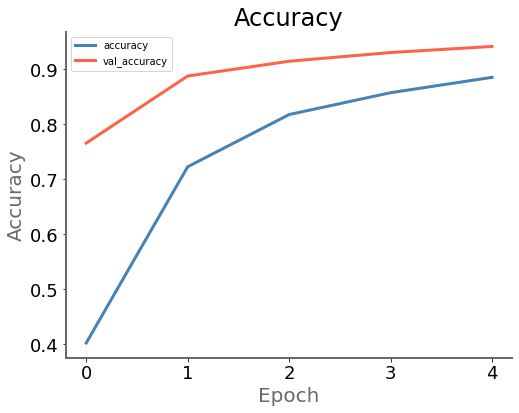

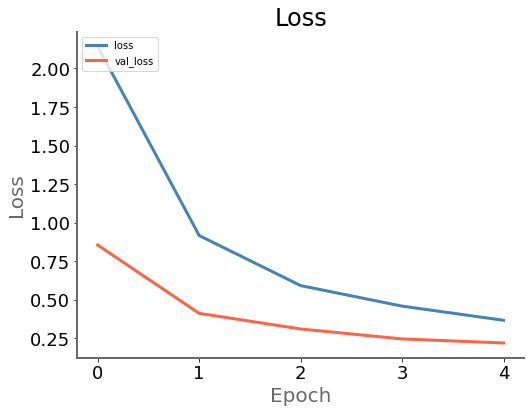

In [13]:
pwk.plot_history(history, save_as='01-history')

## Step 8 - Evaluate best model

### 8.1 - Restore best model :

In [14]:
loaded_model = tf.keras.models.load_model(f'{run_dir}/models/best-model.h5')
# best_model.summary()
print("Loaded.")

Loaded.


### 8.2 - Evaluate it :

In [15]:
score = loaded_model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 0.2195
Test accuracy  : 0.9409


**Plot confusion matrix**

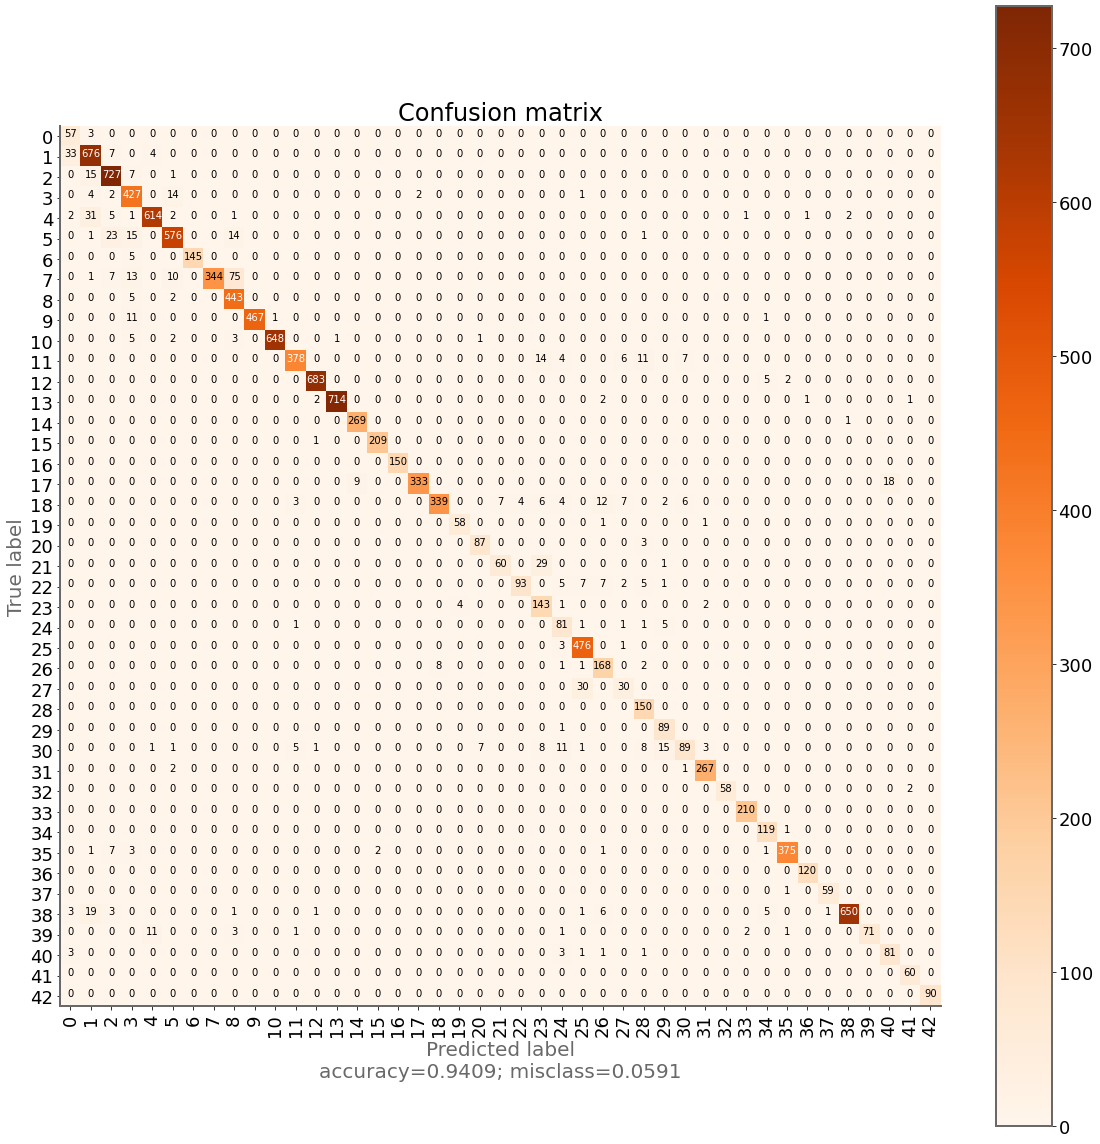

In [16]:
y_sigmoid = model.predict(x_test)
y_pred    = np.argmax(y_sigmoid, axis=-1)

cmap = plt.get_cmap('Oranges')
pwk.plot_confusion_matrix(y_test,y_pred,range(43), figsize=(16, 16),normalize=False, cmap=cmap, save_as='02-confusion-matrix')

In [17]:
pwk.end()

End time is : Tuesday 09 February 2021, 18:48:13
Duration is : 00:01:28 256ms
This notebook ends here


<div class="todo">
     What you can do:
    <ul>
        <li>Try different datasets / models</li>
        <li>Test different hyperparameters (epochs, batch size, optimization, etc.)</li>
        <li>What's the best strategy?  How to compare?</li>
    </ul>
    
</div>

---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>